In [3]:
import _nb_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from prompter import *
from data import *
from utils import *
from model import GenParams, GoogleAIStudioMLLM, OllamaMLLM
from viz import display_prompt

from IPython.display import Markdown
from concurrent.futures import ThreadPoolExecutor, as_completed # for paralellism
import time
import re

# Inference

In [16]:
# model_name = "gemma3:4b-it-q4_K_M"
# model_name = "gemma3:4b-it-qat"
# model_name = "gemma3:12b"
# model_name = "gemma3:12b-it-qat"
# model_name = "gemma3:27b"
# model_name = "gemma3:27b-it-qat"
# model_name = "qwen2.5vl:7b-q4_K_M"
# model_name = "qwen2.5vl:7b-q8_0"
# model_name = "hf.co/unsloth/Mistral-Small-3.1-24B-Instruct-2503-GGUF:Q4_K_M"

model_name = "gemma3:12b-it-qat"
vlm = OllamaMLLM(model_name)
# vlm: GoogleAIStudioMLLM = GoogleAIStudioMLLM(model_name="gemma-3-27b-it", api_key=GOOGLE_AI_KEY)

llm_judge: GoogleAIStudioMLLM = GoogleAIStudioMLLM(model_name="gemini-2.0-flash", api_key=GOOGLE_AI_KEY)

# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
SPLIT_BY = "class-splitted"

promptBuilder = PromptBuilder(
    by_model            = BY_MODEL,
    alpha               = 0.75,
    image_size          = 224,
    array_size          = (32, 32),
    class_map           = CLASS_MAP, # imported from 'class_map.py'
    color_map           = COLOR_MAP_DICT,
    split_by            = SPLIT_BY
)

gen_params = GenParams(seed=CONFIG["seed"], temperature=0.1)

##  Class-splitted Inference

## Single Sample

In [6]:
promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
    input_format_module     = SepMasks_Ovr_InputFormatModule("original"),
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16,)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="4_specify_pos_class_recency_2")
)

In [7]:
query_idx = 5

In [8]:
class_splitted_inference_prompt = promptBuilder.build_class_splitted_inference_prompts(query_idx)
class_splitted_inference_prompt.keys()

dict_keys([9, 12, 18])

In [9]:
%timeit promptBuilder.build_class_splitted_inference_prompts(query_idx)

1.07 s ± 40.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
class_splitted_inference_prompt[12]

['I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.\n',
 'In both masks, a color-class mapping is applied: the white color is mapped to the DOG class, while the black color refers to unlabelled classes.\n',
 'I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.\nBoth images are overlaid with the scene to support your analysis.\n',
 '## Instructions\n\nYour task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.\n',
 'I provide some examples of correct outputs:\n- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN

In [35]:
list(["A", "B", "C"]).index("R")

ValueError: 'R' is not in list

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In both masks, a color-class mapping is applied: the white color is mapped to the DOG class, while the black color refers to unlabelled classes.


I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.
Both images are overlaid with the scene to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Ground Truth.

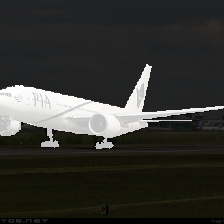

Prediction.

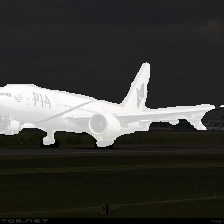

Output:

The ground truth AEROPLANE region has been segmented quite well by the prediction, but the boundaries are imprecise and less defined.

Now, I ask you to generate the output based on the following input. Remember the considered class is the DOG class, reference it explicitely in the answer.


Input:

Ground Truth.

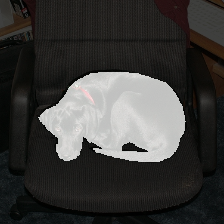

Prediction.

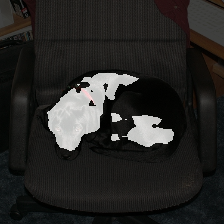

Output:

In [31]:
display_prompt(class_splitted_inference_prompt[12])

In [8]:
class_splitted_answer_pr = await vlm.predict_one_class_splitted(
    class_splitted_inference_prompt,
    query_idx,
    gen_params=gen_params,
    only_text=True,
    splits_in_parallel=False,
)
class_splitted_answer_pr

CancelledError: 

In [22]:
r = await vlm.generate_response(["Hi, who are you?"], gen_params=gen_params, stream=True)
r.text

"Hi there! 👋 I'm Gemma, an open-weights AI assistant. I'm a large language model trained by Google DeepMind. The Gemma team are my creators. \n\nI'm widely available to the public – I'm an *open weights* model, which means I'm pretty accessible! I take text *and* images as inputs and generate text as output. Basically, you can give me a prompt (text or an image!), and I'll do my best to give you a helpful and informative response.\n\nI don't have access to tools, real-time information or Google search.\n\nYou can find more information about me here: [https://ai.google.dev/gemma](https://ai.google.dev/gemma)\n\n\n\n"

In [9]:
class_splitted_eval_prompt = promptBuilder.build_class_splitted_eval_prompt(query_idx, class_splitted_answer_pr["content"])
class_splitted_eval_prompt.keys()

dict_keys([9, 12, 18])

In [10]:
# display_prompt(class_splitted_eval_prompt[12])

In [11]:
class_splitted_eval_pr = await llm_judge.predict_one_class_splitted(
    class_splitted_eval_prompt,
    query_idx,
    gen_params=gen_params,
    only_text=True,
    parse_to_dict=True,
    splits_in_parallel=True
)
class_splitted_eval_pr

{'img_idx': 5,
 'content': {9: {'pred': 'incorrect',
   'score': 1,
   'reason': 'The predicted answer focuses on the CHAIR class, but it inaccurately describes the quality of the prediction mask. The ground truth states that the CHAIR region segmentation is irregular, erratic, and has inaccurate boundaries, while the predicted answer claims the mask closely matches the ground truth overall and only mentions minor jagged edges and over-segmentation. This is a significant inconsistency.'},
  12: {'pred': 'correct',
   'score': 4,
   'reason': "The predicted answer accurately identifies several key deviations in the DOG class segmentation compared to the ground truth. It correctly points out the misclassification of non-white (black) regions of the dog as unlabelled, the incomplete segmentation of white regions, and the overall deviation from the ground truth. While it doesn't capture every single detail, it provides a comprehensive and accurate assessment of the DOG class segmentation e

In [12]:
validate_pertinence(class_splitted_answer_pr["content"].values(), class_splitted_answer_pr["content"].keys())
validate_pertinence([d["reason"] for d in class_splitted_eval_pr["content"].values()], class_splitted_eval_pr["content"].keys())

## Pertinence Validation

In [ ]:
input_format = ConcatMasks_Ovr_Hz_InputFormatModule("original")

promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
    input_format_module     = input_format,
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="4_specify_pos_class_recency_2")
)

In [ ]:
epoch_idxs = list(range(23))
epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
batches_idxs = partition_list(epoch_idxs, 7)
num_batches = len(batches_idxs)
batches_idxs

NameError: name 'partition_list' is not defined

### Validate Answers

In [ ]:
epoch_answer_pr_dicts = {}
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")
 
def process_class_splitted_predict(promptBuilder, query_idx):
    return query_idx, vlm.class_splitted_predict_one(promptBuilder, query_idx)

for i, batch_idxs in enumerate(batches_idxs):

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: process_class_splitted_predict(promptBuilder, idx), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, answer_pr_dict = future.result()
            epoch_answer_pr_dicts[query_idx] = answer_pr_dict

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ConcatMasks_Ovr_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.


In [ ]:
for img_idx, pos_class_2_answer_pr in epoch_answer_pr_dicts.items():
    validate_pertinence(pos_class_2_answer_pr.values(), pos_class_2_answer_pr.keys())

### Validate Evals

In [ ]:
epoch_eval_pr_dicts = {}
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")

def process_class_splitted_evaluate(promptBuilder, query_idx):
    pos_class_2_eval_prompt = promptBuilder.build_class_splitted_eval_prompt(query_idx, epoch_answer_pr_dicts[query_idx])
    return query_idx, vlm.class_splitted_evaluate_one(pos_class_2_eval_prompt)

for i, batch_idxs in enumerate(batches_idxs):

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: process_class_splitted_evaluate(promptBuilder, idx), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, eval_pr_dict = future.result()
            epoch_eval_pr_dicts[query_idx] = eval_pr_dict

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ConcatMasks_Ovr_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.


In [ ]:
wrong_eval_idxs = []
n_evals = 0
for img_idx, pos_class_2_eval_pr in epoch_eval_pr_dicts.items():
    eval_reasons = [eval_pr["reason"] for eval_pr in pos_class_2_eval_pr.values()]
    n_evals += len(eval_reasons)
    try:
        validate_pertinence(eval_reasons, pos_class_2_eval_pr.keys())
    except:
        wrong_eval_idxs.append(img_idx)

In [ ]:
len(wrong_eval_idxs)

0

In [ ]:
wrong_idx = wrong_eval_idxs[0]
wrong_idx

IndexError: list index out of range

In [ ]:
print("GROUND TRUTH ANSWER:")
display(get_one_answer_gt(BY_MODEL, wrong_idx, False))
print("PREDICTED ANSWER:")
display(epoch_answer_pr_dicts[wrong_idx])
print("PREDICTED EVAL:")
display({k: v["reason"] for k, v in epoch_eval_pr_dicts[wrong_idx].items()})

GROUND TRUTH ANSWER:


{3: 'The prediction masks for the two ground truth TRAIN regions have some coarser boundaries, many details are lost.'}

PREDICTED ANSWER:


{15: 'The prediction mask does not contain any PERSON class, while the ground truth mask does not contain any PERSON class either. Therefore, there are no significant deviations.\n',
 19: 'The prediction mask of the TRAIN class is incomplete, especially in the lower part of the scene. The TRAIN region on the right side of the scene is also missing some parts. The boundaries of the predicted TRAIN regions are also less defined and more irregular compared to the ground truth.\n'}

PREDICTED EVAL:


{15: 'The predicted answer states that both the prediction and ground truth masks do not contain the PERSON class, and therefore there are no significant deviations. This aligns with the ground truth\'s implicit statement that "Both masks have no PERSON in them, so there is no deviation".',
 19: 'The predicted answer correctly identifies that the prediction mask of the TRAIN class is incomplete and that the boundaries are less defined and more irregular compared to the ground truth. The predicted answer is consistent with the ground truth answer.'}

## Pipeline

In [17]:
input_format = SepMasks_Ovr_InputFormatModule("original")

promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = ClassSplitted_ColorMapModule(variation="default"),
    input_format_module     = input_format,
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16,)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="4_specify_pos_class_recency_2")
)

prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")

**Save Paths**

In [18]:
exp_name = "speed_test"

In [19]:
answer_path = get_answer_prs_root_path("LRASPP_MobileNet_V3", "class-splitted") / model_name / exp_name / "SepMasks_Ovr_1fs.jsonl"
eval_path = get_eval_prs_root_path("LRASPP_MobileNet_V3", "class-splitted") / model_name / exp_name / "SepMasks_Ovr_1fs.jsonl"
print(answer_path)
print(eval_path)

/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl
/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/eval_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl


### Evaluation

In [20]:
epoch_answer_list, answer_state = get_many_eval_pr(answer_path, return_state=True, format_to_dict=False)
len(epoch_answer_list)

79

In [21]:
epoch_idxs = [d["img_idx"] for d in epoch_answer_list]
len(epoch_idxs)

79

In [22]:
class_splitted_eval_prompts = [promptBuilder.build_class_splitted_eval_prompt(img_idx, epoch_answer_list[i]["content"]) for i, img_idx in my_tqdm(epoch_idxs)]
len(class_splitted_eval_prompts)

  0%|          | 0/79 [00:00<?, ?item/s]

KeyError: 0

In [11]:
append_many_to_jsonl(eval_path, [answer_state | {"llm_judge": f"{llm_judge.__class__.__name__}:{llm_judge.model}"}]) 

In [ ]:
print(f"Evaluating {prompt_desc}.")

epoch_eval_list = []

epoch_eval_list += await llm_judge.predict_many_class_splitted(
    class_splitted_eval_prompts,
    epoch_idxs,
    gen_params=gen_params,
    jsonl_save_path=eval_path,
    only_text=True,
    parse_to_dict=True,
    splits_in_parallel=True,
    batch_size=11,
    cooldown_period=60
)

Evaluating SepMasks_Ovr.


100%|██████████| 4/4 [03:05<00:00, 46.42s/item]
